# 🧠 Introducción: Hiperplanos, neuronas y regresión logística

Este cuaderno implementa y visualiza, paso a paso, un **clasificador logístico lineal** en 2D. El objetivo es mostrar cómo una **sola neurona** (modelo lineal con función sigmoide) aprende una **frontera de decisión** que separa dos clases mediante un **hiperplano** (recta en 2D).

## 🎯 Objetivos de aprendizaje

- Construir el modelo probabilístico  
  $p(y = 1 \mid \mathbf{x}) = \sigma(z)$ con  
  $z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 = \beta^\top \mathbf{x}$.

- Maximizar la **log-verosimilitud**:  

  $LL(\beta) = \sum_i \Big[y_i \log p_i + (1 - y_i)\log(1 - p_i)\Big], \quad p_i = \sigma(\beta^\top \mathbf{x}_i)$  
  mediante **gradiente ascendente**:  
  
  $\beta := \beta + \eta\,\nabla LL(\beta), \qquad \nabla LL(\beta) = \mathbf{X}_c^\top(\mathbf{Y} - \mathbf{p})$

- Visualizar la **frontera de decisión** dada por $\sigma(z) = 0.5 \iff z = 0$, es decir:  
  $\beta_0 + \beta_1 x + \beta_2 y = 0 \;\Rightarrow\; y = \frac{-\beta_0 - \beta_1 x}{\beta_2}$

---

## 🧩 Qué verás en el cuaderno
1. **Importaciones y configuración**: parámetros del experimento ($\eta$, iteraciones, tamaño de muestra).
2. **Funciones clave**:  
   - $\sigma(z) = \dfrac{1}{1 + e^{-z}}$ (**sigmoide**),  
   - $LL(\beta)$ (**log-verosimilitud**),  
   - $\nabla LL(\beta)$ y **regla iterativa** para actualizar $\beta$.
3. **Generación de datos sintéticos**:  
   - **Escenario linealmente separable** (dos nubes gaussianas).  
   - *(Opcional, comentado)* **Escenario no lineal** (centro vs. anillo) para evidenciar limitaciones de un hiperplano.
4. **Entrenamiento** por **gradiente ascendente** hasta convergencia.  
5. **Gráfica final**: datos de ambas clases y **recta** $\sigma(z) = 0.5$.

---

## 📈 Resultados esperados
- Con datos **separables**, el algoritmo encuentra una recta que divide adecuadamente ambas nubes.  
- La **magnitud del gradiente** disminuye y $LL(\beta)$ se estabiliza.  
- En el caso **no lineal** (si se activa), una única neurona **no** separa perfectamente, motivando modelos de mayor capacidad.



## 📦 Importamos librerías básicas

Estas librerías se utilizarán a lo largo del cuaderno:

- **NumPy** → para cálculos vectorizados, operaciones con matrices y vectores aleatorios.  
- **Matplotlib** → para visualizar los datos y la frontera de decisión del modelo.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# NumPy nos permite manejar vectores y matrices, realizar el producto punto y aplicar funciones matemáticas.
# Matplotlib se usa para graficar los datos generados y visualizar la frontera (hiperplano) que separa las clases.

## ⚙️ Variables de configuración

Definimos los parámetros generales del experimento:

- `tam_clase`: cantidad de muestras por clase.
- `eta`: tasa de aprendizaje (α) que controla la magnitud de cada actualización del gradiente.
- `max_it`: número máximo de iteraciones del entrenamiento.

Estas variables determinan la **velocidad y estabilidad** del aprendizaje del modelo.


In [18]:
tam_clase = 100   # número de ejemplos en cada clase (azul y roja)
eta = 0.001       # tasa de aprendizaje para el gradiente ascendente
max_it = 10000    # límite de iteraciones de entrenamiento



## Sigmoide y Gradiente ascendente

En esta sección se implementan las **funciones matemáticas fundamentales** del modelo de **regresión logística**, encargadas de transformar los datos de entrada y ajustar los parámetros del modelo durante el aprendizaje.

---

### 🔹 Función sigmoide

La **sigmoide** es una función no lineal que convierte un número real en una **probabilidad entre 0 y 1**.

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Si $z \to +\infty$, entonces $\sigma(z) \to 1$  
Si $z \to -\infty$, entonces $\sigma(z) \to 0$  
En $z = 0$, $\sigma(0) = 0.5$




Esta transformación permite **interpretar la salida** del modelo como la **probabilidad** de que un punto pertenezca a la clase positiva (Y=1).  
Por eso, es la función de activación típica de una **neurona logística**.

---

### 🔹 Gradiente ascendente

El método de **gradiente ascendente** busca los valores de los parámetros \( \beta \) que **maximizan** la función de **log-verosimilitud**:

$$
LL(\beta) = \sum_i [y_i \log p_i + (1 - y_i)\log(1 - p_i)]
$$

Su **gradiente** indica hacia dónde crece esta función:

$$
\nabla LL(\beta) = X_c^\top (Y - p)
$$

y la **regla de actualización** ajusta los pesos:

$$
\beta := \beta + \eta \, \nabla LL(\beta)
$$

donde:
- \( \eta \) es la **tasa de aprendizaje**
- el proceso se repite hasta que el gradiente sea pequeño (convergencia)

---

### 🧩 En resumen:
Estas funciones permiten que la neurona logística:
1. Calcule probabilidades a partir de combinaciones lineales $z = \beta^\top X$.  
2. Aprenda los valores óptimos de $\beta$ moviéndose en la dirección donde $LL(\beta)$ crece.  
3. Encuentre una frontera que separa las clases según $\sigma(z) = 0.5$.




In [19]:
# ----------------------------
# 🧩 Funciones auxiliares
# ----------------------------

def sigmoide(z):
    """
    Calcula la función sigmoide:
        σ(z) = 1 / (1 + e^{-z})
    - Transforma cualquier número real (z) en una probabilidad entre 0 y 1.
    - Es usada como función de activación en la regresión logística.
    """
    return 1 / (1 + np.exp(-z))  # aplica la fórmula de la sigmoide


def grad_asc(Xc, Y, eta=0.1, max_it=10000):
    """
    Implementa el algoritmo de Gradiente Ascendente para estimar los parámetros β.

    Parámetros:
    - Xc: matriz con las características de entrada (m muestras x n variables)
    - Y: vector columna con las etiquetas de salida (0 o 1)
    - eta: tasa de aprendizaje (controla la magnitud del ajuste en cada paso)
    - max_it: número máximo de iteraciones

    Retorna:
    - beta: vector columna con los parámetros aprendidos (incluyendo el sesgo β0)
    """

    # Obtener dimensiones de la matriz de entrada
    m, n = Xc.shape  # m = número de observaciones, n = número de variables
    # shape: devuelve una tupla con las dimensiones de la matriz Xc

    # Inicialización de los parámetros β (n+1 incluyendo β0)
    beta = np.zeros((n + 1, 1))
    # np.zeros((n + 1, 1)): crea un vector columna de ceros con n+1 filas, el 1 adicional es para el sesgo β0

    # Agregar columna de unos al inicio de Xc para representar el sesgo β0
    X = np.hstack((np.ones((m, 1)), Xc))

    # 🔁 Bucle de iteraciones de entrenamiento
    for i in range(max_it):

        # 1️⃣ Calcular las probabilidades predichas con la sigmoide
        p = sigmoide(X @ beta)
        # X @ beta: producto punto entre la matriz X y el vector beta, resultando en un vector de m probabilidades

        # 2️⃣ Calcular el gradiente de la log-verosimilitud
        #    ∇LL(β) = Xᵀ (Y - p)
        grad = X.T @ (Y - p)
        # X.T: transpuesta de la matriz X (n+1 x m)

        # 3️⃣ Evaluar la norma del gradiente: si es pequeña, se considera que el modelo convergió
        if np.linalg.norm(grad) < 1e-4:
            break


        # 4️⃣ Actualizar los parámetros β (regla de gradiente ascendente)
        beta = beta + eta * grad
        # eta * grad: escala el gradiente por la tasa de aprendizaje

    # Retornar los parámetros ajustados
    return beta


## 🎲 Datos para ejemplo 1 — Nubes separables linealmente

En esta sección generamos **dos conjuntos de puntos** (nubes de datos) que representarán dos clases distintas:

- **Clase 1 (Y = 1):** centrada en el cuadrante negativo (alrededor de -2, -2).  
- **Clase 0 (Y = 0):** centrada en el cuadrante positivo (alrededor de +2, +2).  

Cada punto se genera con distribución **normal aleatoria (gaussiana)**, usando `np.random.randn`, lo que simula dispersión natural en los datos.

Estas nubes permiten **visualizar cómo el modelo aprenderá una frontera (recta)** que las separa.

---

### 🧠 Fundamento teórico

Cada punto generado representa un **vector aleatorio**  
$$
\mathbf{x}_i = (x_{1i}, x_{2i})
$$  
que pertenece a una de dos distribuciones:

- Clase 1: alrededor de $(-2, -2)$  
- Clase 0: alrededor de $(+2, +2)$  

Estas muestras forman el conjunto de datos de entrenamiento.  
El modelo logístico buscará los parámetros $\beta$ que mejor separen ambas clases.

---

### 📈 Resultado esperado
- Dos grupos de puntos bien separados en el plano.  
- La media (`promedio`) de los datos de la clase 1 debería estar cerca de -2.  
- Sirve para verificar que las muestras se generaron correctamente.


In [20]:
# Generación de datos sintéticos para ejemplo 1

# Clase 1 (Y = 1): centrada en (-2, -2)
# np.random.randn genera valores ~ N(0,1), por eso restamos 2 para desplazar la media.
X1_true = np.random.randn(tam_clase, 1) - 2   # Coordenada X1
X2_true = np.random.randn(tam_clase, 1) - 2   # Coordenada X2

# Clase 0 (Y = 0): centrada en (+2, +2)
# Sumamos 2 para mover la nube al cuadrante positivo.
X1_false = np.random.randn(tam_clase, 1) + 2  # Coordenada X1
X2_false = np.random.randn(tam_clase, 1) + 2  # Coordenada X2

# 🔧 Aseguramos que las matrices tengan la forma correcta (muestras x 1)
X1_true  = X1_true.reshape(tam_clase, 1)
X2_true  = X2_true.reshape(tam_clase, 1)
X1_false = X1_false.reshape(tam_clase, 1)
X2_false = X2_false.reshape(tam_clase, 1)

# 📊 Cálculo de la media de X1 para verificar desplazamiento
promedio = np.mean(X1_true)

# 🖨️ Visualización rápida para confirmar la generación
print("Primeros valores de X1_true:\n", X1_true)
print("Promedio de X1_true:", promedio)

print(X1_true)
print(promedio)



Primeros valores de X1_true:
 [[-1.94759618]
 [-1.19583937]
 [-3.33883281]
 [-1.70180564]
 [-1.44947528]
 [-3.28131577]
 [-1.82269873]
 [-2.05932423]
 [-1.72594359]
 [-2.41664137]
 [-0.52513762]
 [-0.67452745]
 [-1.07165493]
 [-2.43936376]
 [-0.21990016]
 [-0.68753442]
 [ 0.08795136]
 [-2.50170386]
 [-1.86173134]
 [-2.629682  ]
 [-3.01312677]
 [-1.80941883]
 [-2.64391537]
 [-0.82675499]
 [-1.87454054]
 [-3.92896872]
 [-2.8486003 ]
 [ 0.6033476 ]
 [-2.2511485 ]
 [-2.4463354 ]
 [-2.93288609]
 [-2.69372796]
 [ 0.17464518]
 [-2.15056981]
 [-2.59979141]
 [-1.12840316]
 [-0.4543824 ]
 [-2.94529658]
 [-3.31216942]
 [-2.06023032]
 [-1.91394391]
 [-2.40056595]
 [ 0.54607081]
 [-0.50296119]
 [-1.9811758 ]
 [-3.04225894]
 [-2.15226694]
 [-3.00943266]
 [-0.78077231]
 [-2.06419228]
 [-2.90156211]
 [-2.05781133]
 [-1.64037833]
 [-2.08577565]
 [-2.67090464]
 [-2.48322217]
 [-1.98469966]
 [-0.95031369]
 [-3.22142032]
 [-1.42567871]
 [-1.14662322]
 [-1.18030692]
 [-0.82750855]
 [-0.91587222]
 [-1.02177

## Datos para ejemplo 2

In [21]:
# Clase "true" (roja) en el centro
###########################################################################
#r_true = 0.5 * np.random.rand(tam_clase)  # radio pequeño para el centro
#theta_true = 2*np.pi*np.random.rand(tam_clase)
#X1_true = (r_true * np.cos(theta_true)).reshape(tam_clase,1)
#X2_true = (r_true * np.sin(theta_true)).reshape(tam_clase,1)
###########################################################################

# Clase "false" (azul) en un anillo alrededor
###########################################################################
#r_false = 1 + 0.3*np.random.rand(tam_clase)  # radio más grande
#theta_false = 2*np.pi*np.random.rand(tam_clase)
#X1_false = (r_false * np.cos(theta_false)).reshape(tam_clase,1)
#X2_false = (r_false * np.sin(theta_false)).reshape(tam_clase,1)
###########################################################################


## Cálculo de betas (entrenamiento con gradiente ascendente)

**Objetivo.**  
Construir el **dataset final** y entrenar la neurona logística para estimar los parámetros  
$\beta = [\beta_0, \beta_1, \beta_2]^\top$ que definen el **hiperplano de decisión**.

---

**Cómo se arma el dataset:**

- Unimos por **columnas** (`hstack`) cada nube para formar matrices de dos columnas:  
  - $X_{\text{true}} = [X1_{\text{true}},\, X2_{\text{true}}]$ (clase 1)  
  - $X_{\text{false}} = [X1_{\text{false}},\, X2_{\text{false}}]$ (clase 0)
- Unimos por **filas** (`vstack`) ambas clases para obtener la matriz total $X$ (aquí llamada `Xc`).  
- Construimos el vector de **etiquetas** $Y$ apilando unos (clase 1) y ceros (clase 0).

---

**Entrenamiento.**  
Llamamos a `grad_asc(Xc, Y, eta, max_it)` que implementa:

$$
\nabla LL(\beta) = X_c^\top (Y - p),
\quad
\beta := \beta + \eta \, \nabla LL(\beta)
$$

> 💡 El término de sesgo $\beta_0$ se maneja internamente al agregar una columna de unos en la matriz $X_c$.

---

**Resultado esperado.**
- Se imprimen los valores de $\beta$.  
- El signo y la magnitud de $\beta_1$ y $\beta_2$ reflejan la **inclinación y dirección** del hiperplano que mejor separa:  
  - la nube centrada en $(-2, -2)$ (clase 1), y  
  - la nube centrada en $(+2, +2)$ (clase 0).


In [22]:
# Construcción de X e Y y entrenamiento para obtener β

# 1) Une por columnas (cada fila es un punto (x1, x2))
X_true  = np.hstack((X1_true,  X2_true))   # (tam_clase x 2)  → clase 1
X_false = np.hstack((X1_false, X2_false))  # (tam_clase x 2)  → clase 0

# 2) Une por filas para formar el dataset completo (2*tam_clase x 2)
Xc = np.vstack((X_true, X_false))

# 3) Vector de etiquetas (2*tam_clase x 1): unos para clase 1, ceros para clase 0
Y = np.vstack((
    np.ones((tam_clase, 1)),   # Y=1 para la nube “true”
    np.zeros((tam_clase, 1))   # Y=0 para la nube “false”
))

# 4) Entrenamiento por gradiente ascendente
#    - eta controla el tamaño del paso
#    - max_it es el tope de iteraciones
#    La función grad_asc agrega la columna de unos para β0 y aplica la regla:
#       β := β + η * X^T (Y - p), con p = σ(Xβ)
betas = grad_asc(Xc, Y, eta, max_it)

# 5) Inspección de resultados
print("β aprendidos [β0, β1, β2]:\n", betas.reshape(-1))


[[-0.07434827]
 [-3.62393599]
 [-4.76443127]]


## 📈 Graficación de datos y frontera de decisión

En esta última parte visualizamos los resultados del modelo logístico:

- Los puntos **azules** representan la **clase 1 (Y=1)** centrada en (-2, -2).  
- Los puntos **rojos** representan la **clase 0 (Y=0)** centrada en (+2, +2).  
- La **línea negra discontinua** muestra el **hiperplano aprendido** (en 2D es una recta).

---

### 🧠 Fundamento teórico

El hiperplano de decisión se obtiene cuando la **probabilidad predicha** por el modelo es 0.5:

$$
\sigma(z) = 0.5 \quad \Longleftrightarrow \quad z = 0
$$

donde:
$$
z = \beta_0 + \beta_1 x + \beta_2 y
$$

Despejando para \( y \):

$$
y = \frac{-\beta_0 - \beta_1 x}{\beta_2}
$$

Esta ecuación define la **recta de separación** entre las dos clases.

---

### 📈 Resultado esperado
- Dos nubes de puntos separadas por una **línea de frontera**.  
- Si el modelo entrenó correctamente, la línea quedará entre ambas nubes.  
- Esto demuestra que la regresión logística **aprendió un hiperplano que clasifica correctamente** los puntos.


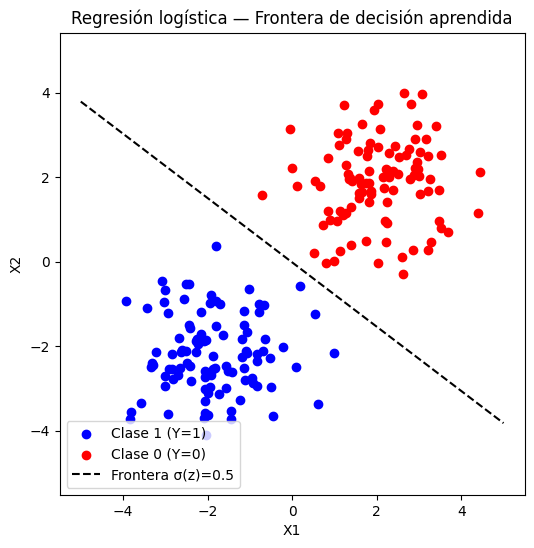

In [24]:
# 📈 Graficación de datos y frontera de decisión (hiperplano en 2D)

# Extraemos los coeficientes β aprendidos
B0 = betas[0, 0]  # Sesgo o término independiente
B1 = betas[1, 0]  # Peso asociado a X1
B2 = betas[2, 0]  # Peso asociado a X2

# Ecuación del hiperplano: β0 + β1*x + β2*y = 0  →  y = (-β0 - β1*x)/β2
x = np.linspace(-5, 5, 100)   # valores de X1
y = (-B0 - B1 * x) / B2       # valores de X2 (frontera de decisión)

# 🔹 Gráfica
plt.figure(figsize=(6, 6))

# Puntos de clase 1 (azul)
plt.scatter(X1_true, X2_true, color='blue', label='Clase 1 (Y=1)')

# Puntos de clase 0 (rojo)
plt.scatter(X1_false, X2_false, color='red', label='Clase 0 (Y=0)')

# Frontera de decisión (línea discontinua negra)
plt.plot(x, y, "k--", label='Frontera σ(z)=0.5')

# Detalles visuales
plt.legend()
plt.title("Regresión logística — Frontera de decisión aprendida")
plt.xlabel("X1")
plt.ylabel("X2")
plt.axis("equal")  # Escala 1:1 para no distorsionar la frontera
plt.show()


---

# Regresión logística

En el aprendizaje de máquina, uno de los retos más comunes es **clasificar objetos o situaciones en dos categorías**:  
por ejemplo,

- determinar si un correo es *spam o no spam*,  
- si un paciente está *enfermo o sano*,  
- o si un punto pertenece a la *clase 0 o clase 1* en un plano de datos.

El objetivo es encontrar una **frontera de decisión** que separe correctamente ambas clases.  
Sin embargo, esa frontera **no siempre es evidente** en los datos crudos.  
Ahí es donde entra el modelo **de regresión logística**.

---

## 🧩 ¿Qué hace la regresión logística?

La regresión logística **aprende automáticamente** esa frontera de separación, combinando tres ideas clave:

### 1️⃣ Modelo lineal
Calcula una combinación lineal de las características:  
$$
z = \beta_0 + \beta_1 x_1 + \beta_2 x_2
$$  
Esto define un **hiperplano** que divide el espacio de datos.

---

### 2️⃣ Transformación probabilística
Aplica la función **sigmoide**:  
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$  
que convierte el valor lineal $z$ en una **probabilidad entre 0 y 1**.  
Así, cada punto ya no se clasifica “duro” como 0 o 1, sino que tiene una **probabilidad de pertenencia**.

---

### 3️⃣ Aprendizaje iterativo (gradiente ascendente)
Ajusta los parámetros $\beta$ para **maximizar la log-verosimilitud** $LL(\beta)$,  
es decir, para que las probabilidades predichas sean lo más coherentes posible con las etiquetas reales.  
Lo hace moviéndose paso a paso en la dirección del **gradiente**.

---

## 📚 Tabla resumen de conceptos

| Concepto | Definición (qué es) | Función en el modelo (para qué sirve) | Cómo actúa / Fórmula principal |
|-----------|---------------------|--------------------------------------|-------------------------------|
| **Vector aleatorio** $$\mathbf{X}$$ | Conjunto de variables aleatorias $$X_1, X_2, \dots, X_n$$ que representan las características de un ejemplo. | Representa los **atributos de entrada** del modelo (por ejemplo, $$x_1$$=edad, $$x_2$$=ingresos). | $$\mathbf{x} = [x_1, x_2, \dots, x_n]$$ |
| **Producto punto** $$z = \beta^\top \mathbf{x}$$ | Combinación lineal de las entradas ponderadas por los parámetros del modelo. | Calcula una **activación lineal** antes de aplicar la función sigmoide. Es la base del hiperplano. | $$z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n$$ |
| **Hiperplano** | Conjunto de puntos donde la combinación lineal es cero ($$z=0$$). | Es la **frontera de decisión** que separa las clases. En 2D es una **recta**, en 3D un **plano**. | $$\beta_0 + \beta_1 x + \beta_2 y = 0 \Rightarrow y = \frac{-\beta_0 - \beta_1 x}{\beta_2}$$ |
| **Función sigmoide** $$\sigma(z)$$ | Función matemática que convierte un número real en una probabilidad entre 0 y 1. | Permite interpretar la salida como **probabilidad de clase 1**. | $$\sigma(z) = \frac{1}{1 + e^{-z}}$$ |
| **Probabilidad logística** $$p = \sigma(\beta^\top \mathbf{x})$$ | Valor de salida del modelo tras aplicar la sigmoide. | Asigna una **probabilidad** de que el ejemplo pertenezca a la clase positiva. | $$p_i = \frac{1}{1 + e^{-(\beta^\top \mathbf{x}_i)}}$$ |
| **Verosimilitud** $$L(\beta)$$ | Mide qué tan probable es observar los datos reales dados los parámetros $$\beta$$. | Es la función que el modelo busca **maximizar**. | $$L(\beta) = \prod_i p_i^{y_i}(1-p_i)^{(1-y_i)}$$ |
| **Log-verosimilitud** $$LL(\beta)$$ | Logaritmo natural de la verosimilitud (facilita cálculos). | Se usa como **función objetivo** para el aprendizaje. | $$LL(\beta) = \sum_i [y_i \log p_i + (1 - y_i)\log(1 - p_i)]$$ |
| **Gradiente** $$\nabla LL(\beta)$$ | Vector de derivadas parciales de la log-verosimilitud respecto a $$\beta$$. | Indica la **dirección de crecimiento máximo** de $$LL(\beta)$$. | $$\nabla LL(\beta) = X_c^\top (Y - p)$$ |
| **Gradiente ascendente** | Algoritmo iterativo que actualiza los parámetros $$\beta$$ en la dirección donde $$LL(\beta)$$ crece. | Es el mecanismo de **aprendizaje** del modelo. | $$\beta := \beta + \eta \nabla LL(\beta)$$ |
| **Tasa de aprendizaje** $$\eta$$ | Escalar positivo que controla el tamaño del paso en cada iteración. | Define **qué tan rápido o lento** aprende el modelo. | Si $$\eta$$ es grande → salta el óptimo; si es pequeña → aprendizaje lento. |
| **Criterio de paro (tolerancia)** | Umbral para detener el entrenamiento cuando el gradiente se hace pequeño. | Indica que el modelo llegó a un punto **cercano al óptimo**. | $$||\nabla LL(\beta)|| < 10^{-4}$$ |
| **Parámetros aprendidos** $$\beta = [\beta_0, \beta_1, \beta_2]$$ | Pesos ajustados durante el entrenamiento. | Definen la **posición e inclinación** del hiperplano de decisión. | Determinados iterativamente hasta que $$LL(\beta)$$ se estabiliza. |
| **Clasificación final** | Proceso de asignar clase 1 o 0 según la probabilidad $$p$$. | Traduce la probabilidad a una **decisión binaria**. | Si $$p > 0.5 \Rightarrow \text{clase 1}$$; si $$p < 0.5 \Rightarrow \text{clase 0}$$. |

---

🧠 **Conclusión.**  
La regresión logística combina estadística y optimización para **aprender una frontera lineal** que clasifica correctamente los datos, transformando combinaciones lineales en probabilidades y ajustando los parámetros mediante el **gradiente ascendente** hasta lograr la máxima verosimilitud.
